In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import time
import numpy as np
import matplotlib.pyplot as plt

# Define Vision Transformer class
class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, embed_dim=128, num_heads=4, num_layers=4, num_classes=10):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_embedding = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.classification_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = x.flatten(2).transpose(1, 2)
        x = torch.cat((x, self.positional_embedding.expand(x.shape[0], -1, -1)), dim=1)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Aggregate patch representations
        x = self.classification_head(x)
        return x

# Define NanoGPT Model class for vision tasks
class NanoGPTVision(nn.Module):
    def __init__(self, img_size=28, patch_size=7, embed_dim=128, num_heads=4, num_layers=4, num_classes=10, vocab_size=50000):
        super(NanoGPTVision, self).__init__()
        self.vision_transformer = VisionTransformer(img_size, patch_size, embed_dim, num_heads, num_layers, embed_dim)  # Set num_classes to embed_dim
        self.text_model = nn.Linear(1, embed_dim)  # Adjust input size of linear layer to match the adjusted shape of tokens

    def forward(self, images, tokens):
        vision_output = self.vision_transformer(images)
        
        # Reshape tokens to match the expected shape for matrix multiplication
        tokens = tokens.view(tokens.size(0), 1)
        
        # Convert tokens to float data type before passing to the linear layer
        tokens = tokens.float()
        
        text_output = self.text_model(tokens)
        combined_output = vision_output + text_output  # Combine vision and text features
        return combined_output

# Data transformations and loaders
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = FashionMNIST(root='./data', train=False, transform=transform, download=True)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, loss, optimizer, and scheduler
model = NanoGPTVision().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
total_training_time = 0.0
num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images, torch.zeros(images.shape[0], dtype=torch.long).to(device))

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()

    epoch_time = time.time() - start_time
    total_training_time += epoch_time

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images, torch.zeros(images.shape[0], dtype=torch.long).to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {100 * correct / total:.2f}%, Epoch Time: {epoch_time:.2f} seconds')

print(f'Total Training Time: {total_training_time:.2f} seconds')

# Final testing
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images, torch.zeros(images.shape[0], dtype=torch.long).to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Plot images with labels
        fig, axs = plt.subplots(4, 4, figsize=(12, 12))
        for i in range(4):
            for j in range(4):
                idx = i * 4 + j
                img = images[idx].cpu().numpy().squeeze()
                axs[i, j].imshow(img, cmap='gray')
                axs[i, j].set_title(f'Label: {class_names[labels[idx].item()]}\nPredicted: {class_names[predicted[idx].item()]}')
                axs[i, j].axis('off')
        plt.show()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')


Epoch [1/10], Test Accuracy: 79.02%, Epoch Time: 332.19 seconds


KeyboardInterrupt: 

In [ ]:
# accuracy

Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.


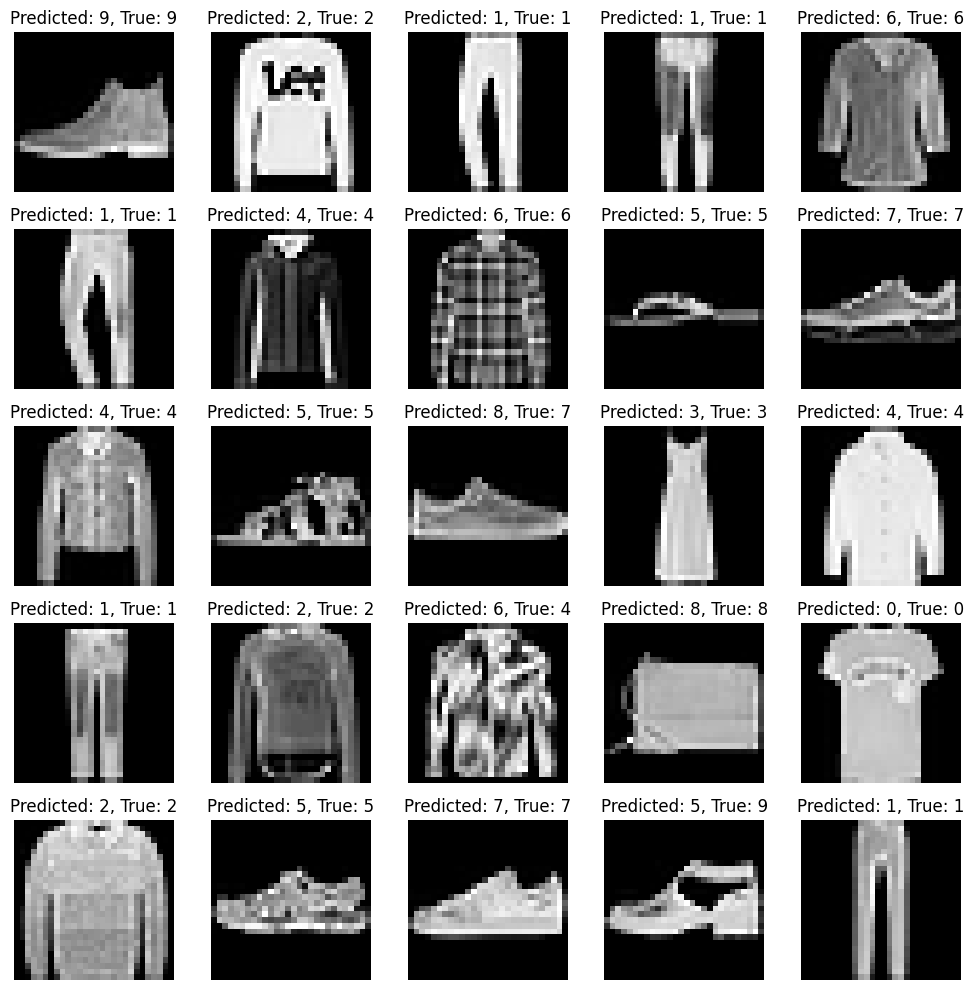

Accuracy of the model on the 10000 test images: 91.00%


In [2]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torchvision import datasets, transforms
# import matplotlib.pyplot as plt
# import numpy as np
# from dataclasses import dataclass
# from torchvision.datasets import FashionMNIST
# from torch.utils.data import DataLoader

# # Adjust GPTConfig for visual data
# @dataclass
# class GPTConfig:
#     block_size: int = 1024
#     vocab_size: int = 50304
#     n_layer: int = 12
#     n_head: int = 12
#     n_embd: int = 768
#     dropout: float = 0.0
#     bias: bool = True

# class LayerNorm(nn.Module):
#     """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

#     def __init__(self, n_features, eps=1e-5):
#         super().__init__()
#         self.normalized_shape = (n_features,)
#         self.weight = nn.Parameter(torch.ones(self.normalized_shape))
#         self.bias = nn.Parameter(torch.zeros(self.normalized_shape))
#         self.eps = eps

#     def forward(self, input):
#         return F.layer_norm(input, self.normalized_shape, self.weight, self.bias, self.eps)

# # Modify GPT to take image input
# class GPT(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.config = config
#         self.conv = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.fc = nn.Linear(32 * 7 * 7, config.n_embd)
#         self.transformer = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
#         self.lm_head = nn.Linear(config.n_embd, config.vocab_size)

#     def forward(self, x, targets=None):
#         x = self.conv(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc(x))
#         for block in self.transformer:
#             x = block(x)
#         logits = self.lm_head(x)
#         if targets is not None:
#             loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets)
#             return logits, loss
#         else:
#             return logits

# # Adjust Block for visual data
# class Block(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.ln_1 = LayerNorm(config.n_embd)
#         self.attn = nn.MultiheadAttention(embed_dim=config.n_embd, num_heads=config.n_head)
#         self.ln_2 = LayerNorm(config.n_embd)
#         self.mlp = nn.Sequential(
#             nn.Linear(config.n_embd, 4 * config.n_embd),
#             nn.GELU(),
#             nn.Linear(4 * config.n_embd, config.n_embd),
#             nn.Dropout(config.dropout)
#         )

#     def forward(self, x):
#         x = x + self.attn(self.ln_1(x), x, x)[0]
#         x = x + self.mlp(self.ln_2(x))
#         return x

# # Load Fashion-MNIST dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# # Model configuration
# config = GPTConfig(n_embd=128, n_head=4, n_layer=4, vocab_size=10)  # 10 classes in Fashion-MNIST

# # Model initialization
# model = GPT(config)

# # Training parameters
# lr = 0.001
# weight_decay = 0.0
# betas = (0.9, 0.999)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
# criterion = nn.CrossEntropyLoss()

# # Training loop
# num_epochs = 5
# batch_size = 64
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# for epoch in range(num_epochs):
#     model.train()
#     for batch_idx, (data, targets) in enumerate(train_loader):
#         data, targets = data.to(device), targets.to(device)
#         optimizer.zero_grad()
#         logits, loss = model(data, targets)
#         loss.backward()
#         optimizer.step()
#     print(f"Epoch {epoch+1}/{num_epochs} completed.")

# # Evaluation
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     fig, axes = plt.subplots(5, 5, figsize=(10, 10))

#     for ax in axes.ravel():
#         ax.axis('off')

#     idx = 0
#     for data, targets in test_loader:
#         data, targets = data.to(device), targets.to(device)
#         outputs = model(data)
#         _, predicted = torch.max(outputs.data, 1)
#         total += targets.size(0)
#         correct += (predicted == targets).sum().item()

#         for i in range(data.size(0)):
#             if idx >= 25:
#                 break
#             image = data[i].cpu().numpy().squeeze()
#             label = predicted[i].cpu().numpy()
#             true_label = targets[i].cpu().numpy()
#             ax = axes[idx // 5, idx % 5]
#             ax.imshow(image, cmap='gray')
#             ax.set_title(f'Predicted: {label}, True: {true_label}')
#             ax.axis('off')
#             idx += 1

#     plt.tight_layout()
#     plt.show()

# accuracy = 100 * correct / total
# print(f'Accuracy of the model on the {total} test images: {accuracy:.2f}%')

# # # Testing
# # model.eval()
# # with torch.no_grad():
# #     correct = 0
# #     total = 0
# #     for images, labels in test_loader:
# #         images = images.to(device)
# #         labels = labels.to(device)
# #         outputs = model(images, torch.zeros(images.shape[0], dtype=torch.long).to(device))  # Dummy text tokens
# #         _, predicted = torch.max(outputs.data, 1)
# #         total += labels.size(0)
# #         correct += (predicted == labels).sum().item()

# #         # Plot images with labels
# #         fig, axs = plt.subplots(4, 4, figsize=(12, 12))
# #         for i in range(4):
# #             for j in range(4):
# #                 idx = i * 4 + j
# #                 img = images[idx].cpu().numpy().squeeze()
# #                 axs[i, j].imshow(img, cmap='gray')
# #                 axs[i, j].set_title(f'Label: {class_names[labels[idx].item()]}\nPredicted: {class_names[predicted[idx].item()]}')
# #                 axs[i, j].axis('off')
# #         plt.show()

# #     print(f'Test Accuracy: {100 * correct / total:.2f}%')